In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, ensemble, tree, linear_model
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import xgboost as xgb

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 22, 4
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_y = train_df.pop('SalePrice') # take out y value
test_id = test_df.pop('Id') # for writing submission file
# also remove id column from train as it will not be used
train_df.drop('Id', axis = 1, inplace=True)

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
print train_df.shape
print test_df.shape

(1460, 79)
(1459, 79)


In [4]:
# check number of nan in both train and test for each columns
def check_null(df):
    null_check = df.isnull().sum(axis=0)
    null = null_check[null_check!=0]
    null_df = df.isnull()
    return null, null_df
train_null, _ = check_null(train_df)
test_null, _ = check_null(test_df)
# print ">>>null value in train:\n", train_null
# print "\n>>>null value in test:\n", test_null

In [5]:
# get rid off columns with missing values more than half
drop_cols1 = [train_null.index[i] for i in range(train_null.shape[0]) if train_null.values[i] > train_df.shape[0]/2]
drop_cols2 = [test_null.index[i] for i in range(test_null.shape[0]) if test_null.values[i] > test_df.shape[0]/2]
drop_cols = list(set(drop_cols1+drop_cols2))
print drop_cols

['PoolQC', 'MiscFeature', 'FireplaceQu', 'Fence', 'Alley']


In [6]:
# drop and impute rest missing data
train_df.drop(drop_cols, axis = 1, inplace=True)
test_df.drop(drop_cols, axis = 1, inplace=True)
# after dropping selected columns, we want to impute which requires
# data to be numeric value, so we proceed to convert categorical data
# but this conversion erases nan, so here we record where the nan is
_, train_nulls = check_null(train_df)
_, test_nulls = check_null(test_df)

In [7]:
# convert object to categorical value first
obj_columns = train_df.select_dtypes(['object']).columns
for col in obj_columns:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    # same conversion should be applied to test data also
    map_col = dict(zip(list(train_df[col].unique()), list(train_df[col].cat.codes.unique())))
    # convert test_df categorical column
    test_df[col] = test_df[col].apply(lambda x: map_col[x]).astype('int')
#     print "Done", col

# now convert train set
train_df[obj_columns] = train_df[obj_columns].apply(lambda x: x.cat.codes)

In [8]:
# get the nan back
train_df[train_nulls] = np.nan
test_df[test_nulls] = np.nan

In [9]:
# impute missing data

# train_filled = SimpleFill().complete(train_df)
train_filled = SoftImpute().complete(train_df)
# train_filled = KNN(k=3).complete(train_df)
# train_filled = MICE().complete(train_df)

test_filled = SoftImpute().complete(test_df)


train_filled = pd.DataFrame(train_filled, columns=train_df.columns)
test_filled = pd.DataFrame(test_filled, columns=test_df.columns)

[SoftImpute] Max Singular Value of X_init = 569792.695239
[SoftImpute] Iter 1: observed MAE=33.836817 rank=7
[SoftImpute] Iter 2: observed MAE=33.644316 rank=6
[SoftImpute] Iter 3: observed MAE=33.305490 rank=6
[SoftImpute] Iter 4: observed MAE=33.232761 rank=6
[SoftImpute] Iter 5: observed MAE=33.215412 rank=6
[SoftImpute] Iter 6: observed MAE=33.211095 rank=6
[SoftImpute] Iter 7: observed MAE=33.209985 rank=6
[SoftImpute] Stopped after iteration 7 for lambda=11395.853905
[SoftImpute] Max Singular Value of X_init = 449876.391390
[SoftImpute] Iter 1: observed MAE=29.721956 rank=8
[SoftImpute] Iter 2: observed MAE=29.755301 rank=8
[SoftImpute] Iter 3: observed MAE=29.438489 rank=7
[SoftImpute] Iter 4: observed MAE=29.319541 rank=7
[SoftImpute] Iter 5: observed MAE=29.291801 rank=7
[SoftImpute] Iter 6: observed MAE=29.284988 rank=7
[SoftImpute] Iter 7: observed MAE=29.283290 rank=7
[SoftImpute] Stopped after iteration 7 for lambda=8997.527828


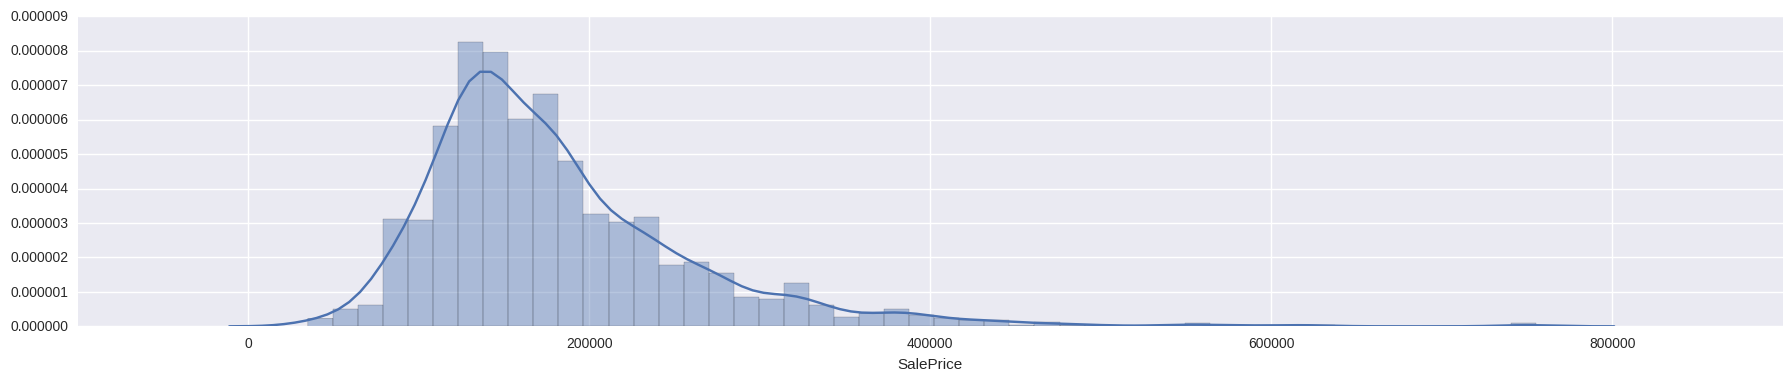

In [10]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_y)

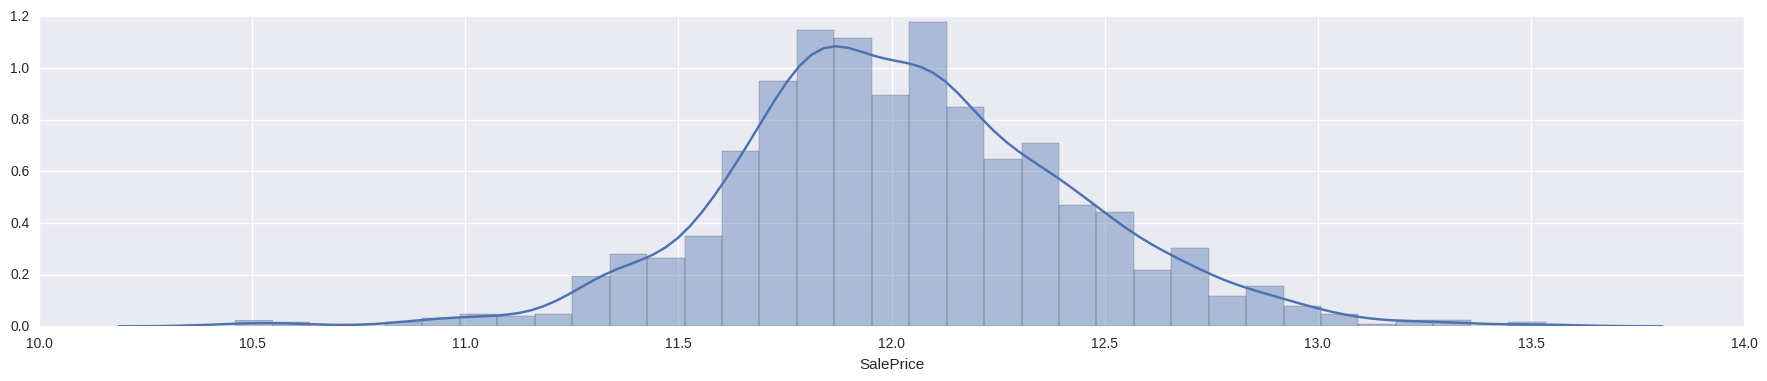

In [11]:
## we can log transform y value
train_y = np.log(train_y)
ax = sns.distplot(train_y)

In [12]:
# standarize non-categoorical values
std_features = list(set(train_filled.columns)-set(obj_columns))
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
train_filled[std_features] = ss.fit_transform(train_filled[std_features])
test_filled[std_features] = ss.transform(test_filled[std_features])

In [13]:
# ax = sns.pairplot(train_filled[std_features[:5]])

### train regression model

In [14]:
# rcParams['figure.figsize'] = 22, 10
# n_cv = 5
# for n_i in range(n_cv):
#     print "[CV {}]".format(n_i)
#     x_train, x_val, y_train, y_val = train_test_split(train_filled.values, train_y.values, 
#                                                       test_size=0.1, random_state=42+n_i)

#     bst = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01, max_depth=3, 
#                            max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber',random_state=42)
#     bst.fit(x_train, y_train)
#     # make prediction
#     preds = bst.predict(x_val)
#     # convert prediction and validation label back to regular scale
#     preds = np.exp(preds)
#     y_val = np.exp(y_val)
#     r2 = metrics.r2_score(y_val, preds)
#     ms = metrics.mean_squared_error(y_val, preds)
#     print "r2:", r2
#     print "RMSLE:", np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
# #     xgb.plot_importance(bst)
# #     xgb.plot_tree(bst,num_trees=10)
    

In [15]:
def train_predict(train_X, train_Y, test_X, verbose=False):
    n_cv = 500
    prediction = []
    for n_i in range(n_cv):
        if verbose:
            print "[CV {}]".format(n_i)
        x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.1, random_state=42+n_i)
        
        bst = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=3, 
                                                 max_features='sqrt', min_samples_leaf=15, 
                                                 min_samples_split=10, loss='huber',random_state=42+n_i)
        bst.fit(x_train, y_train)
        # make prediction
        preds = bst.predict(x_val)
        # convert prediction and validation label back to regular scale
        preds = np.exp(preds)
        y_val = np.exp(y_val)
        r2 = metrics.r2_score(y_val, preds)
        ms = metrics.mean_squared_error(y_val, preds)
        print "r2:", r2
        print "RMSLE:", np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
    #     xgb.plot_importance(bst)
    #     xgb.plot_tree(bst,num_trees=10)

        prediction_i = preds = bst.predict(test_X)
        prediction.append(prediction_i)
    
    print "Done training and predicting."
    
    prediction = np.array(prediction)
#     prediction = np.exp(np.array(prediction))
    ensemble_result = []
    n, m = prediction.shape
    p_std = np.std(prediction, axis=0) # along columns
    p_mean = np.mean(prediction, axis=0)
    for i in range(m):
        p_i = prediction[:,i]
        # select predictions that are with 2 std from the mean
        select_i = p_i[(np.abs(p_i-p_mean[i]) < 1.*p_std[i])]
        ensemble_result.append(np.mean(select_i))
    # transform y back to normal scale
    ensemble_result = np.exp(ensemble_result)
    result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble_result})
    result_df.to_csv('./result/result_gb500.csv', index=False)
    
train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)

[CV 0]
r2: 0.886373181416
RMSLE: 0.118526931186
[CV 1]
r2: 0.946379043553
RMSLE: 0.119145244195
[CV 2]
r2: 0.853353321526
RMSLE: 0.134708726471
[CV 3]
r2: 0.926287316964
RMSLE: 0.152720783381
[CV 4]
r2: 0.940403783281
RMSLE: 0.108187669195
[CV 5]
r2: 0.469199630873
RMSLE: 0.202792723172
[CV 6]
r2: 0.938576970057
RMSLE: 0.101048410455
[CV 7]
r2: 0.939456460697
RMSLE: 0.105988839311
[CV 8]
r2: 0.918101142849
RMSLE: 0.128399485283
[CV 9]
r2: 0.931495324517
RMSLE: 0.10448651347
[CV 10]
r2: 0.909565333501
RMSLE: 0.12692442075
[CV 11]
r2: 0.868674704015
RMSLE: 0.13691669837
[CV 12]
r2: 0.763142720006
RMSLE: 0.14015316648
[CV 13]
r2: 0.928972080382
RMSLE: 0.104744819417
[CV 14]
r2: 0.730785376113
RMSLE: 0.166308689027
[CV 15]
r2: 0.929534614363
RMSLE: 0.1230951331
[CV 16]
r2: 0.937198044055
RMSLE: 0.10154340299
[CV 17]
r2: 0.748596835509
RMSLE: 0.13598952593
[CV 18]
r2: 0.828658679829
RMSLE: 0.154858251408
[CV 19]
r2: 0.896823558138
RMSLE: 0.11367595423
[CV 20]
r2: 0.781082637573
RMSLE: 0.141

In [16]:
# def train_predict(train_X, train_Y, test_X, verbose=False):
#     n_cv = 500
#     prediction = []
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)
#         lm_i = linear_model.LinearRegression()
#         lm_i.fit(x_train, y_train)
#         acc_i = lm_i.score(x_val, y_val)
#         print acc_i
        
#         prediction_i = lm_i.predict(test_X)
#         prediction.append(prediction_i)
#     print "Done training and predicting."
    
#     prediction = np.array(prediction)
# #     prediction = np.exp(np.array(prediction))
#     ensemble = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         select_i = p_i[(np.abs(p_i-p_mean[i]) < 2.*p_std[i]) and (p_i>0.8)]
#         ensemble.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble = np.exp(ensemble)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble})
#     result_df.to_csv('result.csv', index=False)
    
# train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)